# YOLO-v2 模型转换与使用

## 1. 使用darknet预训练的权重文件和配置文件，并把它们转化成keras模型。所需要资料如下:

(1)从[YOLO官方网站](https://pjreddie.com/darknet/yolo/)下载YOLO_v2的darknet模型的权重及配置文件：
* yolov2.weights
* yolov2.cfg

(2)从[YARD2K的git库](https://github.com/allanzelener/YAD2K.git)中拉出其代码仓到本地

(3)coco_classes.txt

### 目录结构
![title](./imgs/convert_dir_info.png)

![](./imgs/convert_dir_info.png)

## 导入相关的库

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import platform
import tensorflow
import keras
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from PIL import Image, ImageDraw, ImageFont
import colorsys
from yad2k.models.keras_yolo import yolo_eval, yolo_head
import cv2
from tqdm import tqdm
import time
import  matplotlib
import matplotlib.pyplot as plt
import IPython.display as display

%matplotlib inline

print('Plateform: {}'.format(platform.platform()))
print('Tensorflow version: {}'.format(tensorflow.__version__))
print('Keras version: {}'.format(keras.__version__))

Using TensorFlow backend.


Plateform: Linux-4.13.0-37-generic-x86_64-with-debian-stretch-sid
Tensorflow version: 1.7.0
Keras version: 2.1.5


In [4]:
# 预训练的模型权重及配置文件所在根目录
ROOT_DIR = '/media/yinyunjie/WD_HDD/project/weights'

# 模型目录
MODEL_PATH = os.path.join(ROOT_DIR, 'yolo_v2_models')

# 标签文件路径
CLASSES_FILE_PATH = os.path.join(MODEL_PATH, 'coco_classes.txt')

# 模型名称
MODEL_FILENAME = 'yolov2_coco_608x608.h5'

# 模型文件路径
MODEL_FILE_PATH = os.path.join(MODEL_PATH, MODEL_FILENAME)

# 锚点文件名称
ANCHORS_FILENAME = 'yolov2_coco_608x608_anchors.txt'

# 锚点文件路径
ANCHORS_FILE_PATH = os.path.join(MODEL_PATH, ANCHORS_FILENAME)

# 输入图片大小及通道数
IMAGE_HEIGHT = 608
IMAGE_WEIGHT = 608
IMAGE_CHANNELS = 3

# confidence score
SCORE_THRESHOLD = 0.3

# IOU threshold
IOU_THRESHOLD = 0.5

TEST_PATH = os.path.join(ROOT_DIR, 'images')

OUTPUT_PATH = os.path.join(ROOT_DIR, 'images_out')

In [5]:
if not os.path.exists(OUTPUT_PATH):
    print('Creating output path {}'.format(OUTPUT_PATH))
    os.mkdir(OUTPUT_PATH)

In [6]:
sess = K.get_session()

In [7]:
with open(CLASSES_FILE_PATH) as f:
    class_names = f.readlines()
    
class_names = [c.strip() for c in class_names]

In [10]:
# get anchors (x1,y1, x2,y2, x3,y3, x4,y4, x5,y5)
with open(ANCHORS_FILE_PATH) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)

In [12]:
# load converted model
yolo_model = load_model(MODEL_FILE_PATH)

yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

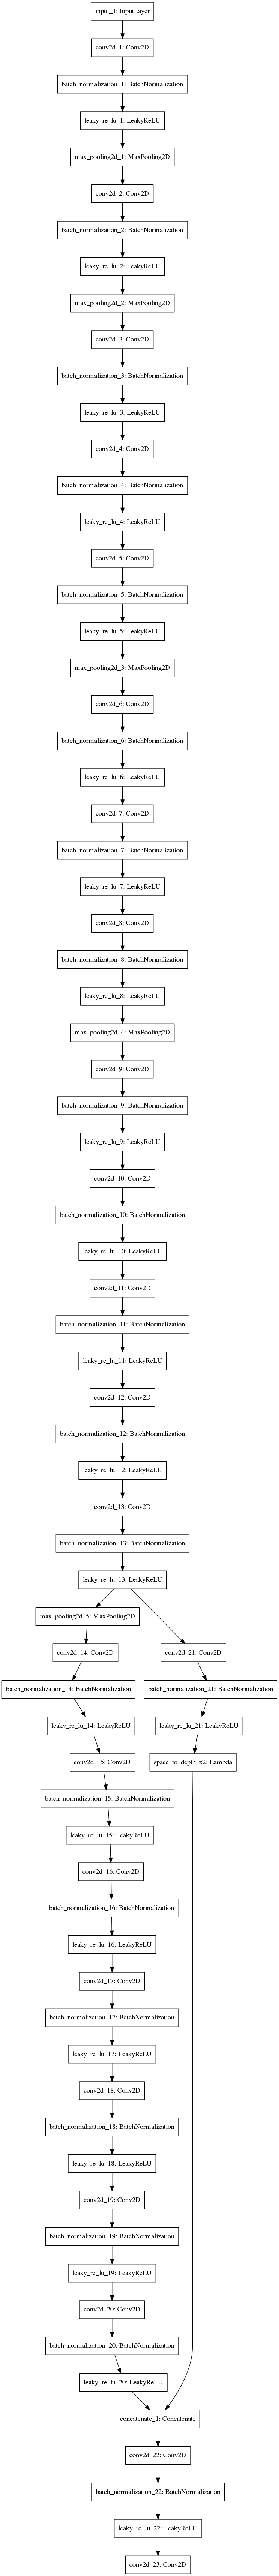

In [13]:
plot_model(yolo_model, to_file='yolov2_model.png')
display.Image('yolov2_model.png')

In [14]:
num_classes = len(class_names)
num_anchors = len(anchors)

# 取出模型的最后一层
model_output_channels = yolo_model.layers[-1].output_shape[-1]

if model_output_channels != (num_anchors * (num_classes + 5)):
    print('Mismatch between model and given anchor and class size!')
    
print('model [{}], anchors[{}], classes[{}] loaded.'.format(MODEL_FILENAME, num_anchors, num_classes))


model [yolov2_coco_608x608.h5], anchors[5], classes[80] loaded.


In [16]:
# check model's input shape
model_image_size = yolo_model.layers[0].input_shape[1:3]
is_fixed_size = model_image_size != (None, None)

print('Flag: is_fixed_size [{}]'.format(is_fixed_size))
print('Model input image size: ', model_image_size)

Flag: is_fixed_size [True]
Model input image size:  (608, 608)


In [33]:
# 对每个bbox画出不同的顔色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]

colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

random.seed(10101)
random.shuffle(colors)
random.seed(None)

In [19]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))

boxes, sores, classes = yolo_eval(yolo_outputs,
                                  input_image_shape,
                                  score_threshold=SCORE_THRESHOLD,
                                  iou_threshold=IOU_THRESHOLD)

## 使用测试图片进行检测

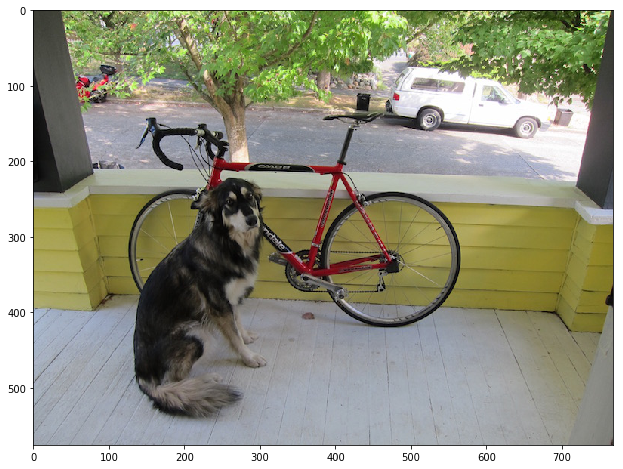

In [21]:
TEST_IMG_NAME = 'dog.jpg'
TEST_IMG_PATH = os.path.join(TEST_PATH, TEST_IMG_NAME)

plt.figure(figsize=(15, 8))
img = plt.imread(TEST_IMG_PATH)
plt.imshow(img)

In [23]:
# 测试数据的预处理
image = Image.open(TEST_IMG_PATH)
print('Before image resize: ', np.array(image, dtype='float32').shape)

resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
image_data = np.array(resized_image, dtype='float32')
print('After image resize: ', image_data.shape)

image_data /= 255.

print('Before expand dims: ', image_data.shape)
image_data = np.expand_dims(image_data, 0)
print('After expand dims: ', image_data.shape)

Before image resize:  (576, 768, 3)
After image resize:  (608, 608, 3)
Before expand dims:  (608, 608, 3)
After expand dims:  (1, 608, 608, 3)


In [25]:
# get predict results
out_boxes, out_scores, out_classes = sess.run(
    [boxes, sores, classes],
    feed_dict={
        yolo_model.input:image_data,
        input_image_shape: [image.size[1], image.size[0]],
        K.learning_phase(): 0
    }
)

print('out_boxes.shape: ', out_boxes.shape, out_boxes.dtype)
print('out_score.shape: ', out_scores.shape, out_scores.dtype)
print('out_classes.shape: ', out_classes.shape, out_classes.dtype)


out_boxes.shape:  (3, 4) float32
out_score.shape:  (3,) float32
out_classes.shape:  (3,) int64


In [27]:
# get predicted data
print('Found {} boxes for {}'.format(len(out_boxes), TEST_IMG_NAME))

# predicted object's: class, score confidence, left-top and right-bottom coordination
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    
    label = '{} {:.2f} [({}, {}), ({}, {})]'.format(
        predicted_class, score, top, left, bottom, right
    )
    
    print(label)

Found 3 boxes for dog.jpg
dog 0.78 [(214, 137), (540, 323)]
truck 0.80 [(82, 462), (168, 694)]
bicycle 0.84 [(112, 81), (469, 554)]


### Display predicted result

dog 0.78 (137, 214) (323, 540)
truck 0.80 (462, 82) (694, 168)
bicycle 0.84 (81, 112) (554, 469)


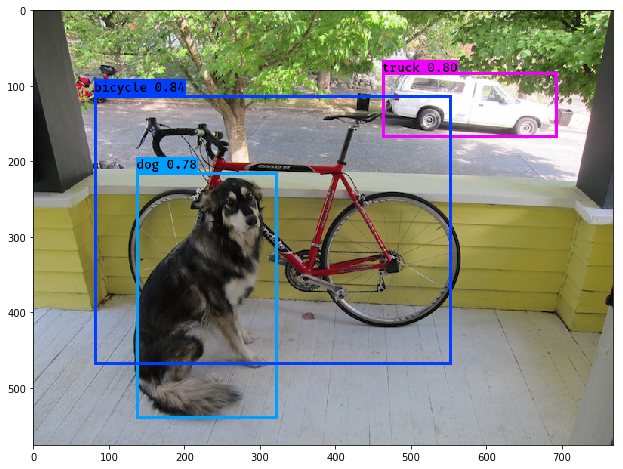

In [34]:
# set font

FONT_TYPE_FILE = 'FiraMono-Medium.otf'
FONT_FILE_PATH = os.path.join(ROOT_DIR, FONT_TYPE_FILE)

font = ImageFont.truetype(font=FONT_FILE_PATH,
                          size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))

# box's thickness
thickness = (image.size[0] + image.size[1]) // 300

for i, c in reversed((list(enumerate(out_classes)))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    
    label = '{} {:.2f}'.format(predicted_class, score)
    draw = ImageDraw.Draw(image)
    label_size = draw.textsize(label, font)
    
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
    
    print(label, (left, top), (right, bottom))
    
    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])
        
    # bbox
    for i in range(thickness):
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c]
        )
        
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=colors[c]
    )
    
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    
    del draw
    
plt.figure(figsize=(15, 8))
plt.imshow(image)